In [51]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [52]:
DATASET_PATH = 'data1'

data_dir = pathlib.Path(DATASET_PATH)


In [53]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))

print('Commands:', commands)

Commands: ['arasa' 'barabar' 'bilkul' 'muli']


In [54]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,
    validation_split=0.2,
    seed=0,
    output_sequence_length=16000,
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 4900 files belonging to 4 classes.
Using 3920 files for training.
Using 980 files for validation.

label names: ['arasa' 'barabar' 'bilkul' 'muli']


In [55]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

In [56]:
def squeeze(audio, labels):
    audio = tf.squeeze(audio, axis=-1)
    return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

In [57]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [58]:
train_ds

<_ParallelMapDataset element_spec=(TensorSpec(shape=(None, 16000), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [59]:
val_ds

<_ShardDataset element_spec=(TensorSpec(shape=(None, 16000), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [60]:
for example_audio, example_labels in train_ds.take(1):  
    print(example_audio.shape)
    print(example_labels.shape)

(64, 16000)
(64,)


In [61]:
label_names[[0,1,2]]

array(['arasa', 'barabar', 'bilkul'], dtype='<U7')

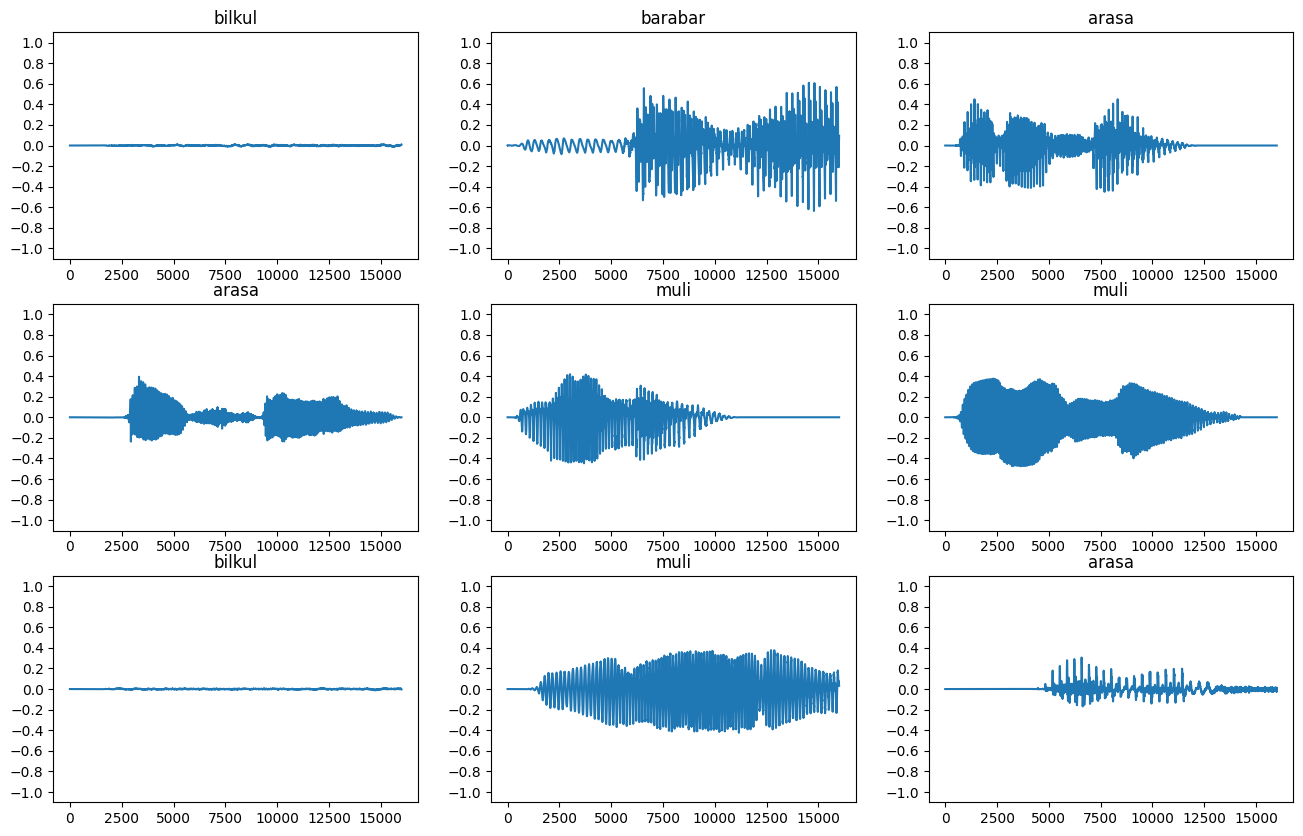

In [62]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i in range(n):
    plt.subplot(rows, cols, i+1)
    audio_signal = example_audio[i]
    plt.plot(audio_signal)
    plt.title(label_names[example_labels[i]])
    plt.yticks(np.arange(-1.2, 1.2, 0.2))
    plt.ylim([-1.1, 1.1])

In [63]:
def get_spectrogram(waveform):
    # Convert the waveform to a spectrogram via a STFT.
    spectrogram = tf.signal.stft(
    waveform, frame_length=255, frame_step=128)
    # Obtain the magnitude of the STFT.
    spectrogram = tf.abs(spectrogram)
    # Add a `channels` dimension, so that the spectrogram can be used
    # as image-like input data with convolution layers (which expect
    # shape (`batch_size`, `height`, `width`, `channels`).
    spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

In [64]:
for i in range(3):
    label = label_names[example_labels[i]]
    waveform = example_audio[i]
    spectrogram = get_spectrogram(waveform)
    print('Label:', label)
    print('Waveform shape:', waveform.shape)
    print('Spectrogram shape:', spectrogram.shape)
    print('Audio playback')
    display.display(display.Audio(waveform, rate=16000))

Label: bilkul
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: barabar
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


Label: arasa
Waveform shape: (16000,)
Spectrogram shape: (124, 129, 1)
Audio playback


In [65]:
def plot_spectrogram(spectrogram, ax):
    if len(spectrogram.shape) > 2:
        assert len(spectrogram.shape) == 3
        spectrogram = np.squeeze(spectrogram, axis=-1)
    # Convert the frequencies to log scale and transpose, so that the time is
    # represented on the x-axis (columns).
    # Add an epsilon to avoid taking a log of zero.
    log_spec = np.log(spectrogram.T + np.finfo(float).eps)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)

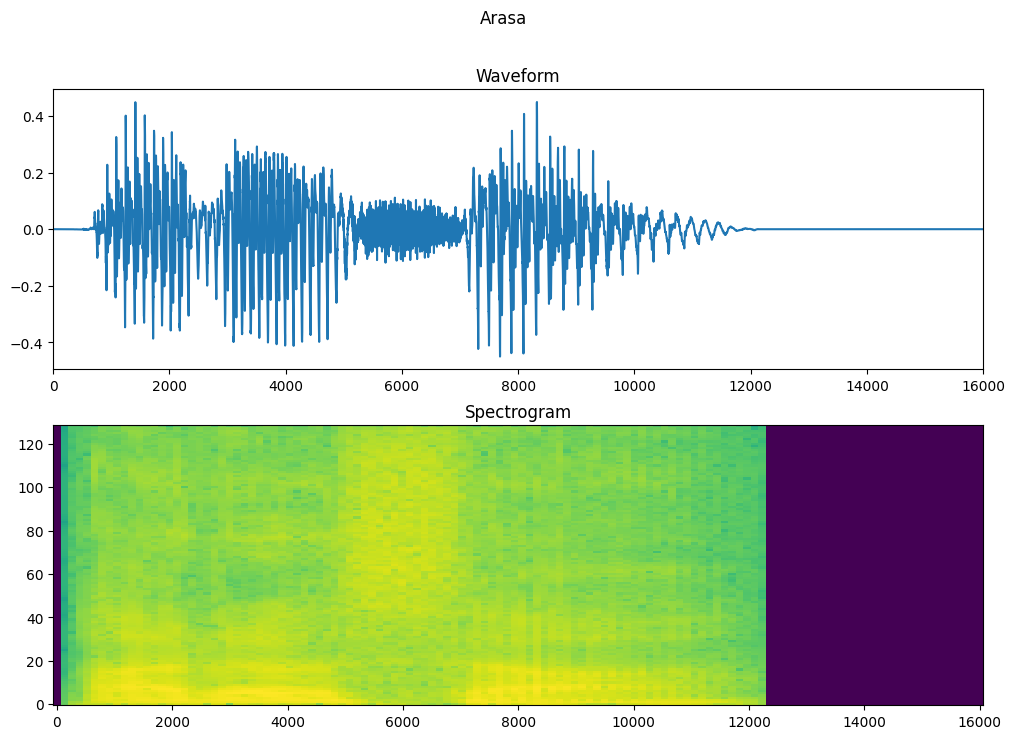

In [66]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

In [67]:
def make_spec_ds(ds):
    return ds.map(map_func=lambda audio,label: (get_spectrogram(audio), label),num_parallel_calls=tf.data.AUTOTUNE)

In [68]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

In [69]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
    break

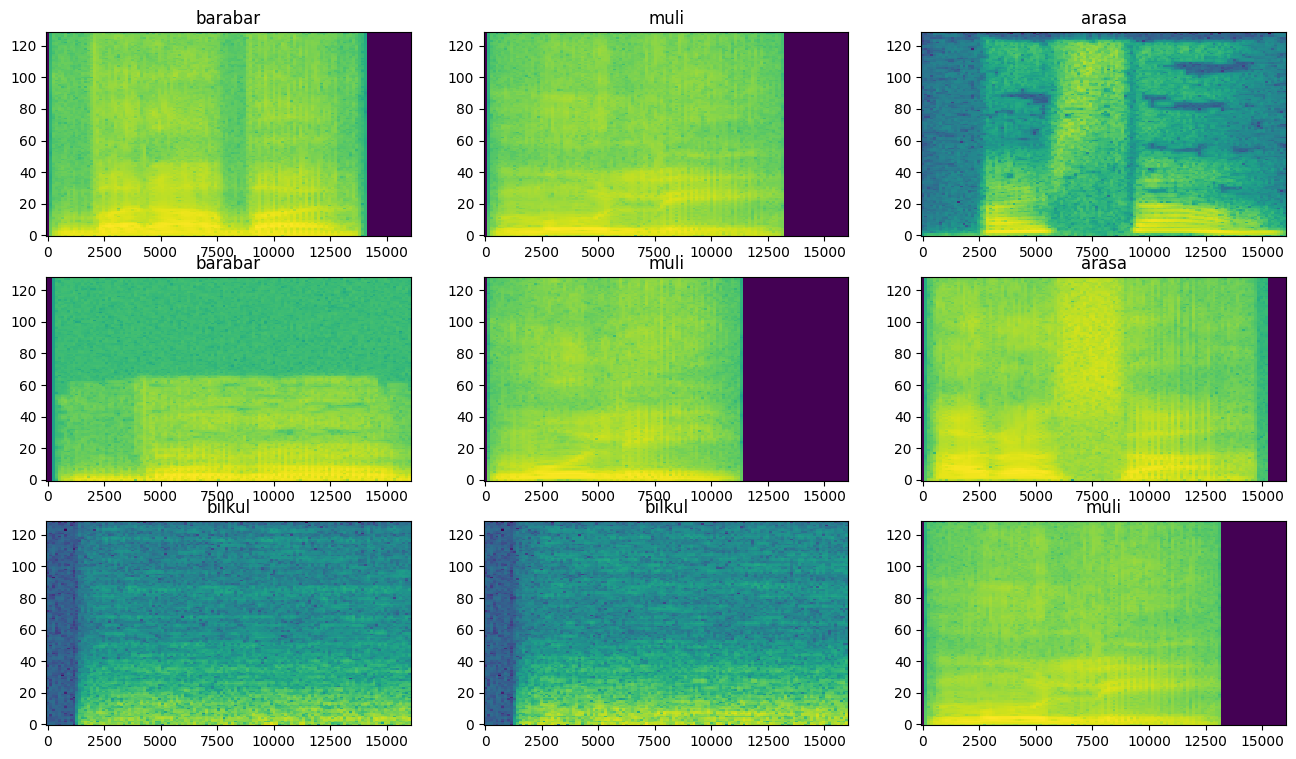

In [70]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

In [71]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [72]:
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_1 (Resizing)       (None, 32, 32, 1)         0         
                                                                 
 normalization_1 (Normaliza  (None, 32, 32, 1)         3         
 tion)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)       

In [73]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [74]:
EPOCHS = 10
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
62/62 [==============================] - 8s 112ms/step - loss: 0.2206 - accuracy: 0.9207 - val_loss: 0.0191 - val_accuracy: 0.9850
Epoch 2/10
62/62 [==============================] - 6s 98ms/step - loss: 0.0150 - accuracy: 0.9949 - val_loss: 0.0043 - val_accuracy: 1.0000
Epoch 3/10
62/62 [==============================] - 6s 94ms/step - loss: 0.0053 - accuracy: 0.9987 - val_loss: 2.1570e-04 - val_accuracy: 1.0000
Epoch 4/10
62/62 [==============================] - 6s 94ms/step - loss: 0.0040 - accuracy: 0.9990 - val_loss: 1.9920e-04 - val_accuracy: 1.0000
Epoch 5/10
62/62 [==============================] - 6s 95ms/step - loss: 0.0036 - accuracy: 0.9992 - val_loss: 3.1927e-04 - val_accuracy: 1.0000
Epoch 6/10
62/62 [==============================] - 6s 94ms/step - loss: 0.0034 - accuracy: 0.9992 - val_loss: 2.4914e-04 - val_accuracy: 1.0000
Epoch 6: early stopping


Text(0, 0.5, 'Accuracy [%]')

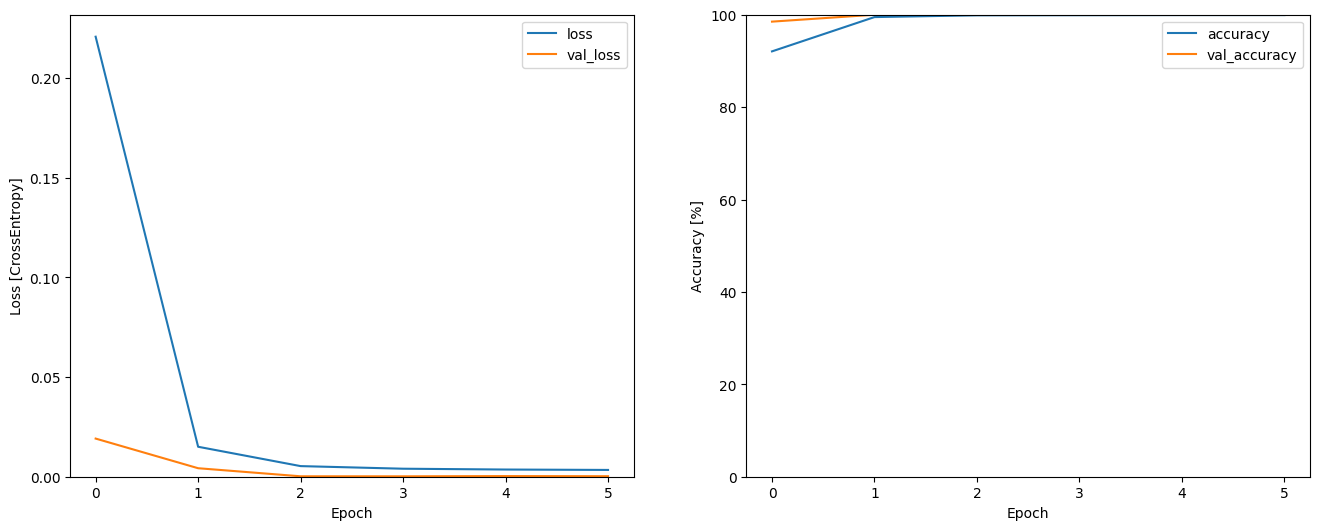

In [75]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

In [76]:
model.evaluate(test_spectrogram_ds, return_dict=True)

8/8 [==============================] - 1s 34ms/step - loss: 3.0624e-04 - accuracy: 1.0000


{'loss': 0.0003062355099245906, 'accuracy': 1.0}

In [77]:
y_pred = model.predict(test_spectrogram_ds)

8/8 [==============================] - 0s 20ms/step


In [78]:
y_pred = tf.argmax(y_pred, axis=1)

In [79]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

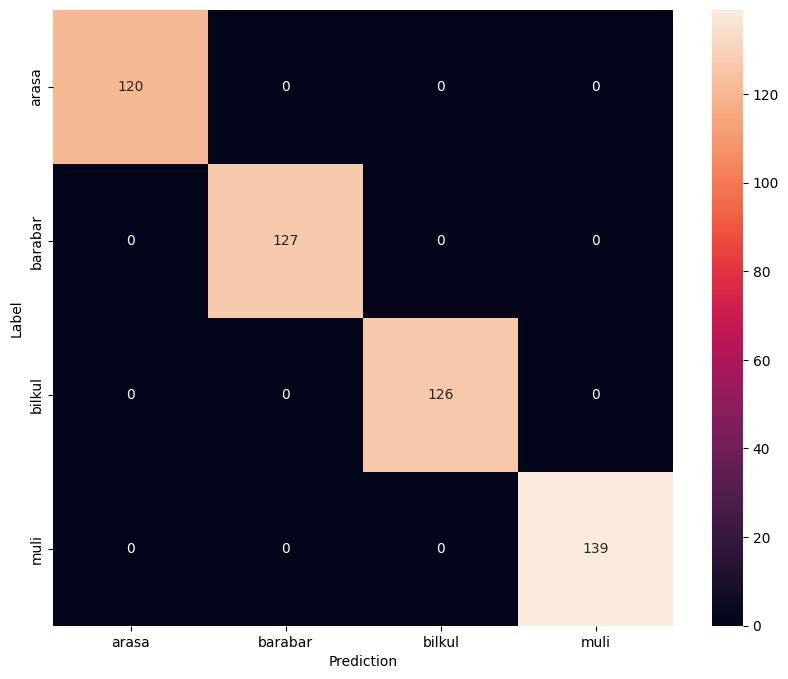

In [80]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

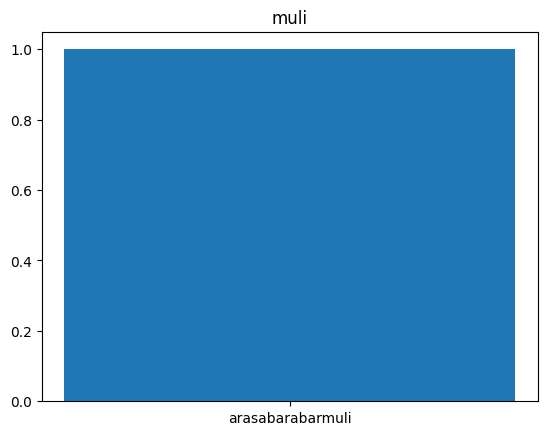

In [81]:
x = '1.wav'
x = tf.io.read_file(str(x))
x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
x = tf.squeeze(x, axis=-1)
waveform = x
x = get_spectrogram(x)
x = x[tf.newaxis,...]

prediction = model(x)
x_labels =['arasa'  'barabar' 'muli']
plt.bar(x_labels, tf.nn.softmax(prediction[0]))
plt.title('muli')
plt.show()

display.display(display.Audio(waveform, rate=16000))

In [82]:
class ExportModel(tf.Module):
    def __init__(self, model):
        self.model = model

        # Accept either a string-filename or a batch of waveforms.
        # YOu could add additional signatures for a single wave, or a ragged-batch. 
        self.__call__.get_concrete_function(
            x=tf.TensorSpec(shape=(), dtype=tf.string))
        self.__call__.get_concrete_function(
           x=tf.TensorSpec(shape=[None, 16000], dtype=tf.float32))
    @tf.function
    def __call__(self, x):
        # If they pass a string, load the file and decode it. 
        if x.dtype == tf.string:
            x = tf.io.read_file(x)
            x, _ = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
            x = tf.squeeze(x, axis=-1)
            x = x[tf.newaxis, :]
    
        x = get_spectrogram(x)  
        result = self.model(x, training=False)
    
        class_ids = tf.argmax(result, axis=-1)
        class_names = tf.gather(label_names, class_ids)
        return {'predictions':result,
            'class_ids': class_ids,
            'class_names': class_names}

In [83]:
export = ExportModel(model)
export(tf.constant(str('1.wav')))

{'predictions': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ -3.044643,   7.047491, -12.85189 ,  18.169096]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([3], dtype=int64)>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'muli'], dtype=object)>}

In [84]:
tf.saved_model.save(export, "saved")
imported = tf.saved_model.load("saved")
imported(waveform[tf.newaxis, :])

INFO:tensorflow:Assets written to: saved\assets


INFO:tensorflow:Assets written to: saved\assets


{'predictions': <tf.Tensor: shape=(1, 4), dtype=float32, numpy=array([[ -3.044643,   7.047491, -12.85189 ,  18.169096]], dtype=float32)>,
 'class_ids': <tf.Tensor: shape=(1,), dtype=int64, numpy=array([3], dtype=int64)>,
 'class_names': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'muli'], dtype=object)>}

In [85]:
a=export(tf.constant(str('1.wav')))

In [86]:
s=str(a['class_names'])

In [87]:
i1=s.index("b'")+2

In [88]:
i2=s.index("']")

In [89]:
cname=s[i1:i2]
cname

'muli'

In [90]:
import pandas as pd
df=pd.read_excel('word_meanings.xlsx')
df

,Word,telugu,tamil,hindi,urdu,Marathi,Kannada
0,puli,tiger,tamarind,NaN,NaN,NaN,NaN
1,kodi,chicken,flag/banner,NaN,NaN,NaN,NaN
2,ma,month,great/big,NaN,NaN,NaN,NaN
3,pora,to search,fight/battle,NaN,NaN,NaN,NaN
4,maata,word/speech,cow,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
72,dhoka,NaN,NaN,betrayal,NaN,danger,NaN
73,shikka,NaN,NaN,coin,NaN,stamp/seal,NaN
74,barabar,NaN,NaN,equal,NaN,correct,NaN
75,muli,NaN,NaN,raddish,NaN,girls,NaN


In [91]:
def get_properties(word):
    global df
    c=0
    if word in df['Word'].values:
        print(f"{word} is present in the 'Word' column.")
        row_number = df.index[df['Word'] == word].tolist()[0] + 1
        print(row_number-1)
        print(df.iloc[row_number-1])
        telugu=df.iloc[row_number-1]['telugu']
        tamil=df.iloc[row_number-1]['tamil']
        hindi=df.iloc[row_number-1]['hindi']
        urdu=df.iloc[row_number-1]['urdu']
        Marathi=df.iloc[row_number-1]['Marathi']
        Kannada=df.iloc[row_number-1]['Kannada']
        print('telugu',telugu)
        print('tamil',tamil)
        print('hindi',hindi)
        print('urdu',urdu)
        print('Marathi',Marathi)
        print('Kannada',Kannada)
        f=open('details.txt','w')
        f.write(str(telugu)+'##'+str(tamil)+'##'+str(hindi)+'##'+str(urdu)+'##'+str(Marathi)+'##'+str(Kannada))
        f.close()
        det='Telugu : '+str(telugu)+'---Tamil  '+str(tamil)+'---Hindi  '+str(hindi)+'---Urdu  '+str(urdu)+'--Marathi  '+str(Marathi)+'---Kannada'+str(Kannada)
        det.replace('nan','NA')
        return det
    else:
        print(f"{word} is not present in the 'Word' column.")
        return 'No Record'

In [92]:
from pydub import AudioSegment
import os

def convert_wav_to_mono(input_folder, output_folder):
    # Iterate through each WAV file in the input folder
    for file_name in os.listdir(input_folder):
        if file_name.endswith(".wav"):
            # Load the WAV file
            audio = AudioSegment.from_wav(os.path.join(input_folder, file_name))
           
            # Convert stereo to mono
            audio = audio.set_channels(1)
           
            # Output file path for the mono WAV file
            #output_path = os.path.join(output_folder, os.path.splitext(file_name)[0] + "_mono.wav")
            output_path = os.path.join(output_folder+"1.wav")
            # Export the audio to mono WAV format
            audio.export(output_path, format="wav")

In [93]:
def predict(apath):
    print('predicting ',apath)
    a=export(tf.constant(str(apath)))
    s=str(a['class_names'])
    i1=s.index("b'")+2
    i2=s.index("']")
    cname=s[i1:i2]
    return cname
    

In [94]:
predict('1.wav')

predicting  1.wav


'muli'

In [95]:
predict('14.wav')

predicting  14.wav


'bilkul'

In [96]:
import sounddevice as sd
import numpy as np
import scipy.io.wavfile as wav

def record_audio(file_name, duration, samplerate):
    print("Recording...")
    recording = sd.rec(int(duration * samplerate), samplerate=samplerate, channels=2, dtype='int16')
    sd.wait()
    print("Recording stopped.")
    wav.write(file_name, samplerate, recording)

def convert_to_mono(input_file, output_file):
    print("Converting to mono...")
    samplerate, data = wav.read(input_file)
    if len(data.shape) == 2:
        mono_data = np.mean(data, axis=1, dtype=data.dtype)
        wav.write(output_file, samplerate, mono_data)
    else:
        print("Already mono channel.")
'''
# Example usage:
if __name__ == "__main__":
    file_name = "recording_stereo.wav"
    mono_file_name = "recording_mono.wav"
    duration = 2  # in seconds
    samplerate = 44100  # in Hz

    record_audio(file_name, duration, samplerate)
    convert_to_mono(file_name, mono_file_name)

'''



'\n# Example usage:\nif __name__ == "__main__":\n    file_name = "recording_stereo.wav"\n    mono_file_name = "recording_mono.wav"\n    duration = 2  # in seconds\n    samplerate = 44100  # in Hz\n\n    record_audio(file_name, duration, samplerate)\n    convert_to_mono(file_name, mono_file_name)\n\n'

In [124]:
import tkinter as tk
import sounddevice as sd
import os
import numpy as np
import scipy.io.wavfile as wav
import tensorflow as tf
import pandas as pd

# Function to convert audio to mono
def convert_to_mono(input_file, output_file):
    print("Converting to mono...")
    samplerate, data = wav.read(input_file)
    if len(data.shape) == 2:
        mono_data = np.mean(data, axis=1, dtype=data.dtype)
        wav.write(output_file, samplerate, mono_data)
    else:
        print("Already mono channel.")

# Function to record audio
def record_audio(file_name, duration, samplerate):
    print("Recording...")
    recording = sd.rec(int(duration * samplerate), samplerate=samplerate, channels=1, dtype='int16')
    sd.wait()
    print("Recording stopped.")
    wav.write(file_name, samplerate, recording)

# Function to predict the language of the recorded audio
def predict_language(audio_file_path):
    # Load the saved model
    model = tf.saved_model.load("saved_model_path")  # Update with your saved model path

    # Convert audio to mono
    convert_to_mono(audio_file_path, "temp_mono.wav")

    # Load the audio and preprocess for prediction
    audio_data, _ = tf.audio.decode_wav(tf.io.read_file("temp_mono.wav"), desired_channels=1)
    audio_data = tf.expand_dims(audio_data, axis=0)
    audio_data = tf.image.resize(audio_data, [16000, 1])  # Resize audio to model input size

    # Make predictions
    predictions = model(audio_data)

    # Get the predicted language label
    language_label = tf.argmax(predictions, axis=1).numpy()[0]

    # Map label to language name
    language_names = ['Telugu', 'Tamil', 'Hindi', 'Urdu', 'Marathi', 'Kannada']
    predicted_language = language_names[language_label]

    return predicted_language

# Function to get the meaning of a language from the Excel sheet
def get_language_meaning(language):
    excel_path = "C:/Users/91734/OneDrive/Desktop/language/word_meanings.xlsx"  # Update with your Excel sheet path
    df = pd.read_excel(excel_path)
    df.set_index('Language', inplace=True)
    meaning = df.loc[language, 'Meaning']
    return meaning

class GUIApp:
    def __init__(self, master):
        self.master = master
        master.title("Language Identification")

        # Buttons
        self.record_button = tk.Button(master, text="Record", command=self.record_audio)
        self.record_button.pack(side="top", pady=10)

        self.predict_button = tk.Button(master, text="Predict Language", command=self.predict_language)
        self.predict_button.pack(side="top", pady=10)

        self.exit_button = tk.Button(master, text="Exit", command=self.exit_app)
        self.exit_button.pack(side="top", pady=10)

        # Whiteboard to display predicted language and meaning
        self.whiteboard = tk.Text(master, wrap="word", width=40, height=10)
        self.whiteboard.pack(side="top", pady=10)

    def record_audio(self):
        duration = 2  # in seconds
        samplerate = 44100  # in Hz
        file_name = "recorded_audio.wav"
        record_audio(file_name, duration, samplerate)
        print("Recording saved as:", file_name)
        
        # Display the recorded word on the whiteboard
        with open(file_name, 'rb') as file:
            recorded_word = file.read()
            self.whiteboard.delete(1.0, tk.END)  # Clear previous text
            self.whiteboard.insert(tk.END, "Recorded Word:\n" + recorded_word.decode("utf-8"))

    def predict_language(self):
        audio_path = "recorded_audio.wav"
        predicted_language = predict_language(audio_path)

        # Get the meaning of the predicted language
        language_meaning = get_language_meaning(predicted_language)

        # Display the predicted language and meaning on the whiteboard
        text = f"Predicted Language: {predicted_language}\nMeaning: {language_meaning}"
        self.whiteboard.delete(1.0, tk.END)  # Clear previous text
        self.whiteboard.insert(tk.END, text)

    def exit_app(self):
        self.master.destroy()

root = tk.Tk()
app = GUIApp(root)
root.mainloop()


Recording...
Recording stopped.
Recording saved as: recorded_audio.wav


Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\91734\anaconda3\lib\tkinter\__init__.py", line 1921, in __call__
    return self.func(*args)
  File "C:\Users\91734\AppData\Local\Temp\ipykernel_11836\3936202239.py", line 90, in record_audio
    self.whiteboard.insert(tk.END, "Recorded Word:\n" + recorded_word.decode("utf-8"))
UnicodeDecodeError: 'utf-8' codec can't decode byte 0xb1 in position 5: invalid start byte
Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\91734\anaconda3\lib\tkinter\__init__.py", line 1921, in __call__
    return self.func(*args)
  File "C:\Users\91734\AppData\Local\Temp\ipykernel_11836\3936202239.py", line 94, in predict_language
    predicted_language = predict_language(audio_path)
  File "C:\Users\91734\AppData\Local\Temp\ipykernel_11836\3936202239.py", line 30, in predict_language
    model = tf.saved_model.load("saved_model_path")  # Update with your saved model path
  File "C:\Users\91734\a